In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyts.image import GramianAngularField
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from sklearn.metrics import root_mean_squared_error, r2_score

In [8]:
df = pd.read_csv("/Users/hanzichun/desktop/Optiver-07/Data/individual_book_train/stock_0.csv")

In [9]:
df['mid_price'] = (df['bid_price1'] + df['ask_price1']) / 2
df['spread'] = df['ask_price1'] - df['bid_price1']
df['log_return'] = np.log(df['mid_price'] / df['mid_price'].shift(1)).fillna(0)

df['realized_volatility'] = (
    df['log_return']
    .rolling(window=30, min_periods=1)
    .apply(lambda x: np.sqrt(np.sum(x**2)))
)

df['rv_future'] = df['realized_volatility'].shift(-30)
df = df.dropna()

window_size = 30
horizon = 30
n_samples = len(df) - window_size - horizon + 1

X_images = []
y = []
gasf = GramianAngularField(method='summation')

feature_scaler = MinMaxScaler(feature_range=(-1, 1))
target_scaler = MinMaxScaler()

for i in range(n_samples):
    ts_window = df['realized_volatility'].iloc[i: i + window_size].values
    ts_norm = feature_scaler.fit_transform(ts_window.reshape(-1, 1)).flatten()
    ts_norm = ts_norm.reshape(1, -1)
    gaf_image = gasf.fit_transform(ts_norm)
    X_images.append(gaf_image[0])

    label = df['rv_future'].iloc[i + window_size - 1]
    y.append(label)

X_images = np.array(X_images)[..., np.newaxis]
y = np.array(y)

y_scaled = target_scaler.fit_transform(y.reshape(-1, 1)).flatten()

split_idx = int(0.8 * len(X_images))
X_train, X_test = X_images[:split_idx], X_images[split_idx:]
y_train, y_test = y_scaled[:split_idx], y_scaled[split_idx:]

model = Sequential([
    Conv2D(16, kernel_size=(3, 3), activation='relu',
           kernel_regularizer=regularizers.l2(0.001),
           input_shape=(window_size, window_size, 1)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(32, kernel_size=(3, 3), activation='relu',
           kernel_regularizer=regularizers.l2(0.001)),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.6),

    Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    shuffle=False,
    verbose=1
)

test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss (MSE): {test_loss:.6f}")

y_pred_scaled = model.predict(X_test).flatten()

y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

rmse = root_mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

def qlike_safe(actual, forecast, eps=1e-8):
    a = np.clip(actual, eps, None)
    f = np.clip(forecast, eps, None)
    r = a / f
    return np.mean(r - np.log(r) - 1.0)

ql = qlike_safe(y_true, y_pred)

print(f"Out-of-sample RMSE: {rmse:.6f}")
print(f"R² score: {r2:.6f}")
print(f"QLIKE: {ql:.6f}")

/Users/hanzichun/Desktop/Optiver-07/volt/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
18350/18350 ━━━━━━━━━━━━━━━━━━━━ 80s 4ms/step - loss: 0.0050 - val_loss: 8.3327e-04
Epoch 2/100
18350/18350 ━━━━━━━━━━━━━━━━━━━━ 77s 4ms/step - loss: 7.8806e-04 - val_loss: 8.3327e-04
Epoch 3/100
18350/18350 ━━━━━━━━━━━━━━━━━━━━ 85s 5ms/step - loss: 7.8806e-04 - val_loss: 8.3327e-04
Epoch 4/100
18350/18350 ━━━━━━━━━━━━━━━━━━━━ 85s 5ms/step - loss: 7.8806e-04 - val_loss: 8.3327e-04
Epoch 5/100
18350/18350 ━━━━━━━━━━━━━━━━━━━━ 92s 5ms/step - loss: 7.8806e-04 - val_loss: 8.3327e-04
Epoch 6/100
18350/18350 ━━━━━━━━━━━━━━━━━━━━ 74s 4ms/step - loss: 7.8806e-04 - val_loss: 8.3327e-04
5735/5735 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 7.7510e-04
Test Loss (MSE): 0.001024
5735/5735 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
Out-of-sample RMSE: 0.001899
R² score: -0.010410
QLIKE: 0.466175


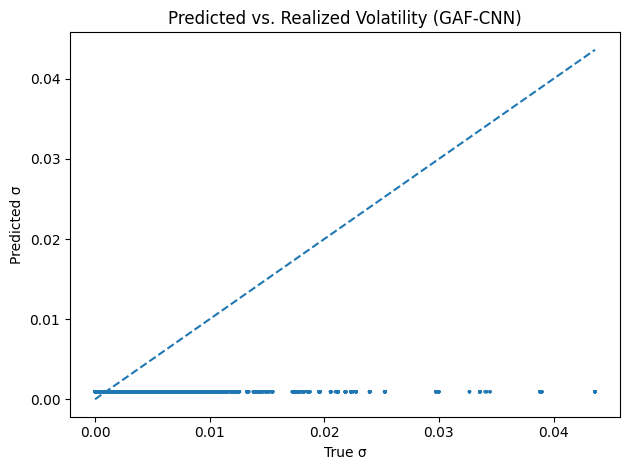

In [10]:
plt.figure()
plt.scatter(y_true, y_pred, s=6, alpha=0.6, edgecolor="none")
max_val = max(np.max(y_true), np.max(y_pred))
plt.plot([0, max_val], [0, max_val], linestyle="--")
plt.title("Predicted vs. Realized Volatility (GAF-CNN)")
plt.xlabel("True σ")
plt.ylabel("Predicted σ")
plt.tight_layout()
plt.show()

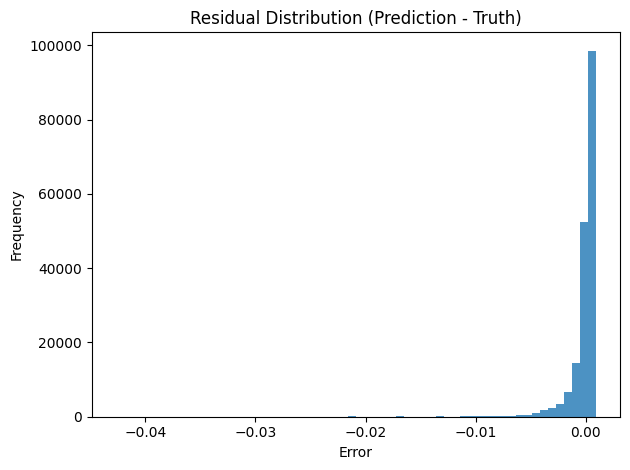

In [11]:
residuals = y_pred - y_true
plt.figure()
plt.hist(residuals, bins=60, alpha=0.8)
plt.title("Residual Distribution (Prediction - Truth)")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

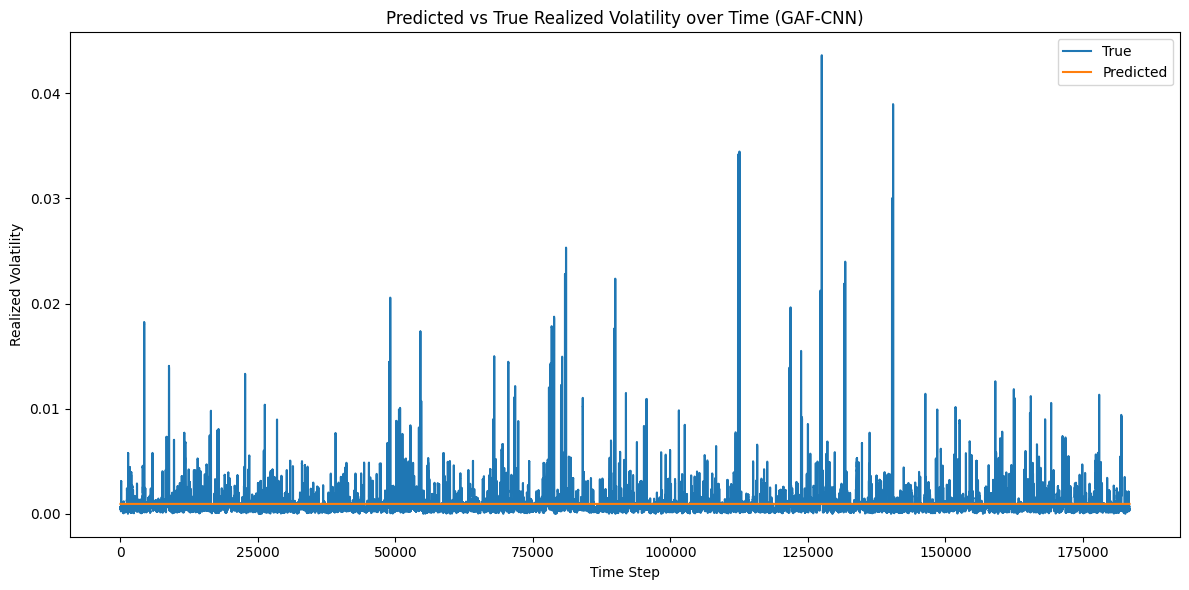

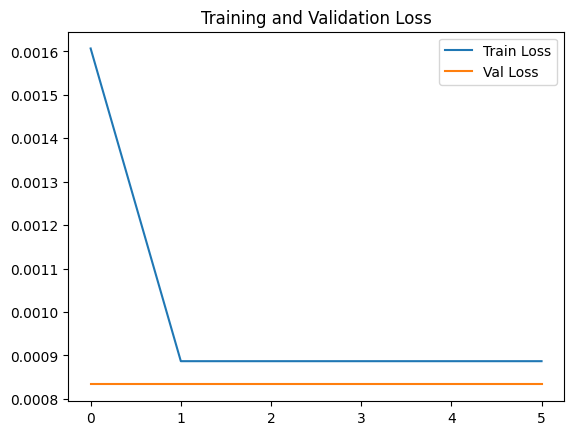

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(y_true, label='True')
plt.plot(y_pred, label='Predicted')
plt.title('Predicted vs True Realized Volatility over Time (GAF-CNN)')
plt.xlabel('Time Step')
plt.ylabel('Realized Volatility')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training and Validation Loss")
plt.legend()
plt.show()